In [210]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm, moyal

In [212]:
path = '20241216_trg123_1950V_8Fe1Pb_10deg_holidaydata.txt'
overflow_value = 1100
Conversion_TDC = np.array([0.09, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10]) * 1e-9 # TDC conversion factors; units (after conversion): seconds
Conversion_ADC = np.array([7.0513, 7.0597, 7.0885, 7.0789, 7.0692, 6.9905, 7.0115, 7.0745]) * 1e-3 # ADC conversion factors; units (after conversion): MeV
dz = 0.1 # PMTs inter-space; units: meters
c = 299792458 # speed of light; units: meters / seconds 

In [214]:
df = pd.read_csv(path, sep = '\t')
df.columns = ['Timestamp'] + [label + str(i) for label in ['ADC', 'TDC'] for i in range(1,9)]
df.head()

,Timestamp,ADC1,ADC2,ADC3,ADC4,ADC5,ADC6,ADC7,ADC8,TDC1,TDC2,TDC3,TDC4,TDC5,TDC6,TDC7,TDC8
0,1734372894,29,170,29,108,22,15,19,15,1437,1181,1181,1181,1180,1180,1180,1180
1,1734373645,516,398,596,432,588,1021,449,16,1438,99,55,102,52,91,49,52
2,1734374556,546,29,32,30,20,17,19,16,1437,84,1181,1181,1181,1181,1181,1181
3,1734376945,517,986,503,326,648,15,31,17,1438,91,50,93,68,72,1182,1182
4,1734377628,780,408,504,349,998,516,635,14,1438,86,57,95,62,77,57,39


In [216]:
df.shape

(1927, 17)

In [218]:
ADC = df.iloc[:, 1:9].copy()
ADC.head()

,ADC1,ADC2,ADC3,ADC4,ADC5,ADC6,ADC7,ADC8
0,29,170,29,108,22,15,19,15
1,516,398,596,432,588,1021,449,16
2,546,29,32,30,20,17,19,16
3,517,986,503,326,648,15,31,17
4,780,408,504,349,998,516,635,14


In [220]:
TDC = df.iloc[:, 9:].copy()
TDC.head()

,TDC1,TDC2,TDC3,TDC4,TDC5,TDC6,TDC7,TDC8
0,1437,1181,1181,1181,1180,1180,1180,1180
1,1438,99,55,102,52,91,49,52
2,1437,84,1181,1181,1181,1181,1181,1181
3,1438,91,50,93,68,72,1182,1182
4,1438,86,57,95,62,77,57,39


In [222]:
# overflown readings
(TDC >= overflow_value).sum()

TDC1    1927
TDC2     408
TDC3     523
TDC4     568
TDC5     783
TDC6     879
TDC7    1053
TDC8    1183
dtype: int64

In [224]:
# events with all readings in overflow
(TDC >= overflow_value).all(axis = 1).sum()

305

In [226]:
TDC = TDC.applymap(lambda x: np.nan if x >= overflow_value else x)
TDC.head()

/var/folders/qb/mpw0pw513fdg_wslyqzyp5fr0000gn/T/ipykernel_1459/2483502495.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TDC = TDC.applymap(lambda x: np.nan if x >= overflow_value else x)


,TDC1,TDC2,TDC3,TDC4,TDC5,TDC6,TDC7,TDC8
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,99.0,55.0,102.0,52.0,91.0,49.0,52.0
2,NaN,84.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,91.0,50.0,93.0,68.0,72.0,NaN,NaN
4,NaN,86.0,57.0,95.0,62.0,77.0,57.0,39.0


In [228]:
# overflown readings
np.isnan(TDC).sum()

TDC1    1927
TDC2     408
TDC3     523
TDC4     568
TDC5     783
TDC6     879
TDC7    1053
TDC8    1183
dtype: int64

In [230]:
# events with all readings in overflow
np.isnan(TDC).all(axis = 1).sum()

305

In [232]:
ADC *= Conversion_ADC
ADC.head()

,ADC1,ADC2,ADC3,ADC4,ADC5,ADC6,ADC7,ADC8
0,0.204488,1.200149,0.205567,0.764521,0.155522,0.104858,0.133219,0.106118
1,3.638471,2.809761,4.224746,3.058085,4.156690,7.137301,3.148164,0.113192
2,3.850010,0.204731,0.226832,0.212367,0.141384,0.118838,0.133219,0.113192
3,3.645522,6.960864,3.565516,2.307721,4.580842,0.104858,0.217357,0.120266
4,5.500014,2.880358,3.572604,2.470536,7.055062,3.607098,4.452303,0.099043


In [234]:
TDC *= Conversion_TDC
TDC.head()

,TDC1,TDC2,TDC3,TDC4,TDC5,TDC6,TDC7,TDC8
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,9.900000e-09,5.500000e-09,1.020000e-08,5.200000e-09,9.100000e-09,4.900000e-09,5.200000e-09
2,NaN,8.400000e-09,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,9.100000e-09,5.000000e-09,9.300000e-09,6.800000e-09,7.200000e-09,NaN,NaN
4,NaN,8.600000e-09,5.700000e-09,9.500000e-09,6.200000e-09,7.700000e-09,5.700000e-09,3.900000e-09


In [236]:
mask = (~np.isnan(TDC)).any(axis = 1)
TDC = TDC.loc[mask]
ADC = ADC.loc[mask]
print(ADC.shape)
print(TDC.shape)

(1622, 8)
(1622, 8)


In [238]:
ADC.join(TDC).head()

,ADC1,ADC2,ADC3,ADC4,ADC5,ADC6,ADC7,ADC8,TDC1,TDC2,TDC3,TDC4,TDC5,TDC6,TDC7,TDC8
1,3.638471,2.809761,4.224746,3.058085,4.156690,7.137301,3.148164,0.113192,NaN,9.900000e-09,5.500000e-09,1.020000e-08,5.200000e-09,9.100000e-09,4.900000e-09,5.200000e-09
2,3.850010,0.204731,0.226832,0.212367,0.141384,0.118838,0.133219,0.113192,NaN,8.400000e-09,NaN,NaN,NaN,NaN,NaN,NaN
3,3.645522,6.960864,3.565516,2.307721,4.580842,0.104858,0.217357,0.120266,NaN,9.100000e-09,5.000000e-09,9.300000e-09,6.800000e-09,7.200000e-09,NaN,NaN
4,5.500014,2.880358,3.572604,2.470536,7.055062,3.607098,4.452303,0.099043,NaN,8.600000e-09,5.700000e-09,9.500000e-09,6.200000e-09,7.700000e-09,5.700000e-09,3.900000e-09
5,7.904507,7.913924,7.946209,7.928368,7.924573,3.907690,7.348052,0.141490,NaN,7.900000e-09,3.100000e-09,8.200000e-09,4.100000e-09,8.200000e-09,6.500000e-09,4.600000e-09


In [240]:
# dt = TDC.diff(axis = 1)
# dt.iloc[:, 0] = TDC.iloc[:, 0]
# dt = dt.rename(columns = lambda s: s.replace('TDC', 'dt'))
# dt = dt.applymap(lambda x: np.nan if x < 0 else x)
# dt.head()

In [242]:
# (~np.isnan(dt.values)).sum(axis = None)

In [244]:
beta = (np.arange(1, 9).astype(float) * dz) / TDC / c
beta = beta.rename(columns = lambda s: s.replace('TDC', 'beta'))
# beta = dz / dt / c
# beta = beta.rename(columns = lambda s: s.replace('dt', 'beta'))
beta.head()

,beta1,beta2,beta3,beta4,beta5,beta6,beta7,beta8
1,NaN,0.067387,0.181944,0.130809,0.320735,0.219932,0.476520,0.513176
2,NaN,0.079420,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.073311,0.200138,0.143468,0.245268,0.277970,NaN,NaN
4,NaN,0.077573,0.175560,0.140448,0.269003,0.259920,0.409640,0.684234
5,NaN,0.084447,0.322804,0.162714,0.406785,0.244071,0.359223,0.580111


In [246]:
gamma = 1 / np.sqrt(1 - beta**2)
gamma = gamma.rename(columns = lambda s: s.replace('beta', 'gamma'))
gamma.head()

/Users/ecedoga/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


,gamma1,gamma2,gamma3,gamma4,gamma5,gamma6,gamma7,gamma8
1,NaN,1.002278,1.016974,1.008667,1.055778,1.025099,1.137445,1.165116
2,NaN,1.003169,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.002698,1.020650,1.010453,1.031507,1.041027,NaN,NaN
4,NaN,1.003022,1.015776,1.010011,1.038271,1.035593,1.096194,1.371248
5,NaN,1.003585,1.056562,1.013507,1.094662,1.031186,1.071522,1.227691


In [248]:
mass = ADC.iloc[:, :-1] / (gamma.iloc[:, 1:].values - gamma.iloc[:, :-1].values) # * (1 / c**2)
mass = np.ravel(mass.values)
mass = mass[(~np.isnan(mass)) & (~np.isinf(mass)) & (mass > 0)]
mass.shape

(3807,)

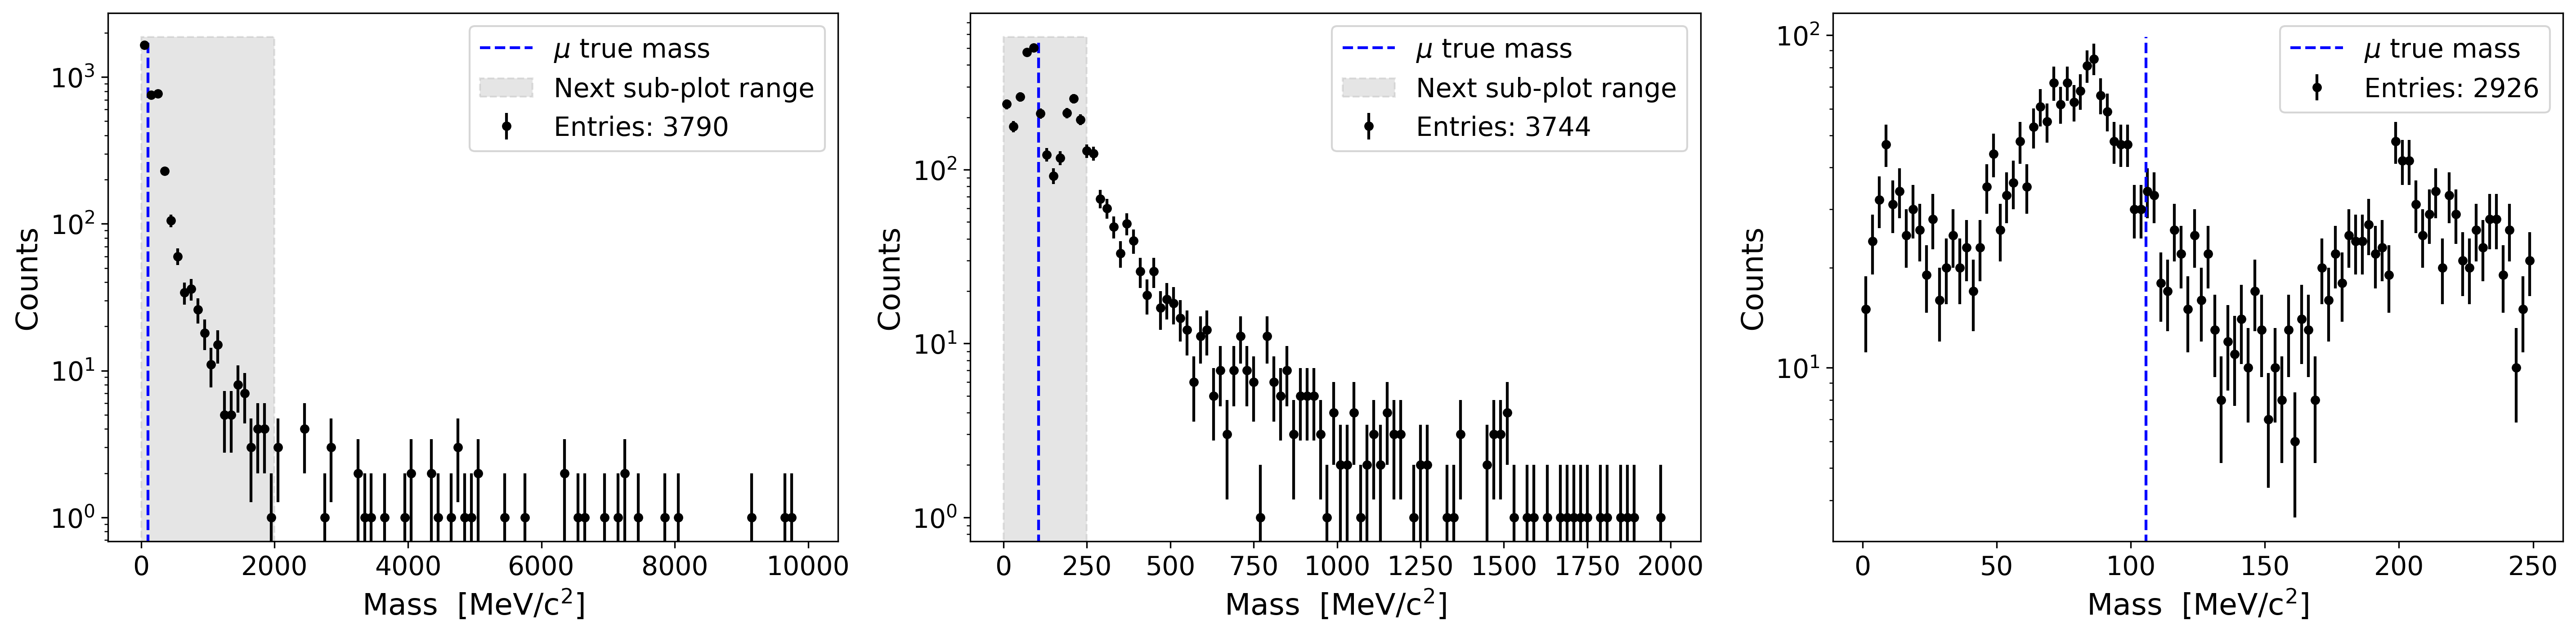

In [260]:
bins = 100
xranges = ([0, 1e4], [0, 2e3], [0, 250])

fig, axs = plt.subplots(1, len(xranges), figsize=(mpl.rcParams['figure.figsize'][0] * len(xranges), mpl.rcParams['figure.figsize'][1]), dpi=300)

for i, ax in enumerate(axs):
    h, b = np.histogram(mass, bins=bins, range=xranges[i])[:2]
    x = (b[1:] + b[:-1]) / 2

    ax.errorbar(x, h, yerr=np.sqrt(h), markersize=4, fmt='o', color='k', label='Entries: {}'.format(np.nansum(h)))[:2]
    ax.vlines([105.66], *ax.get_ylim(), ls='dashed', color='blue', label='$\mu$ true mass')
    
    if i < len(axs) - 1:
        ax.fill_betweenx(ax.get_ylim(), [xranges[i+1][0]]*2, [xranges[i+1][1]]*2, ls='dashed', alpha=0.2, color='gray', label='Next sub-plot range')
    
    ax.set_yscale('log')
    ax.set_xlabel('Mass  [MeV/c$^2$]', fontsize=16)
    ax.set_ylabel('Counts', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend(fontsize=14, loc='upper right')

plt.tight_layout()
plt.savefig('8Fe1Pb10degmass', dpi=300)
plt.show()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


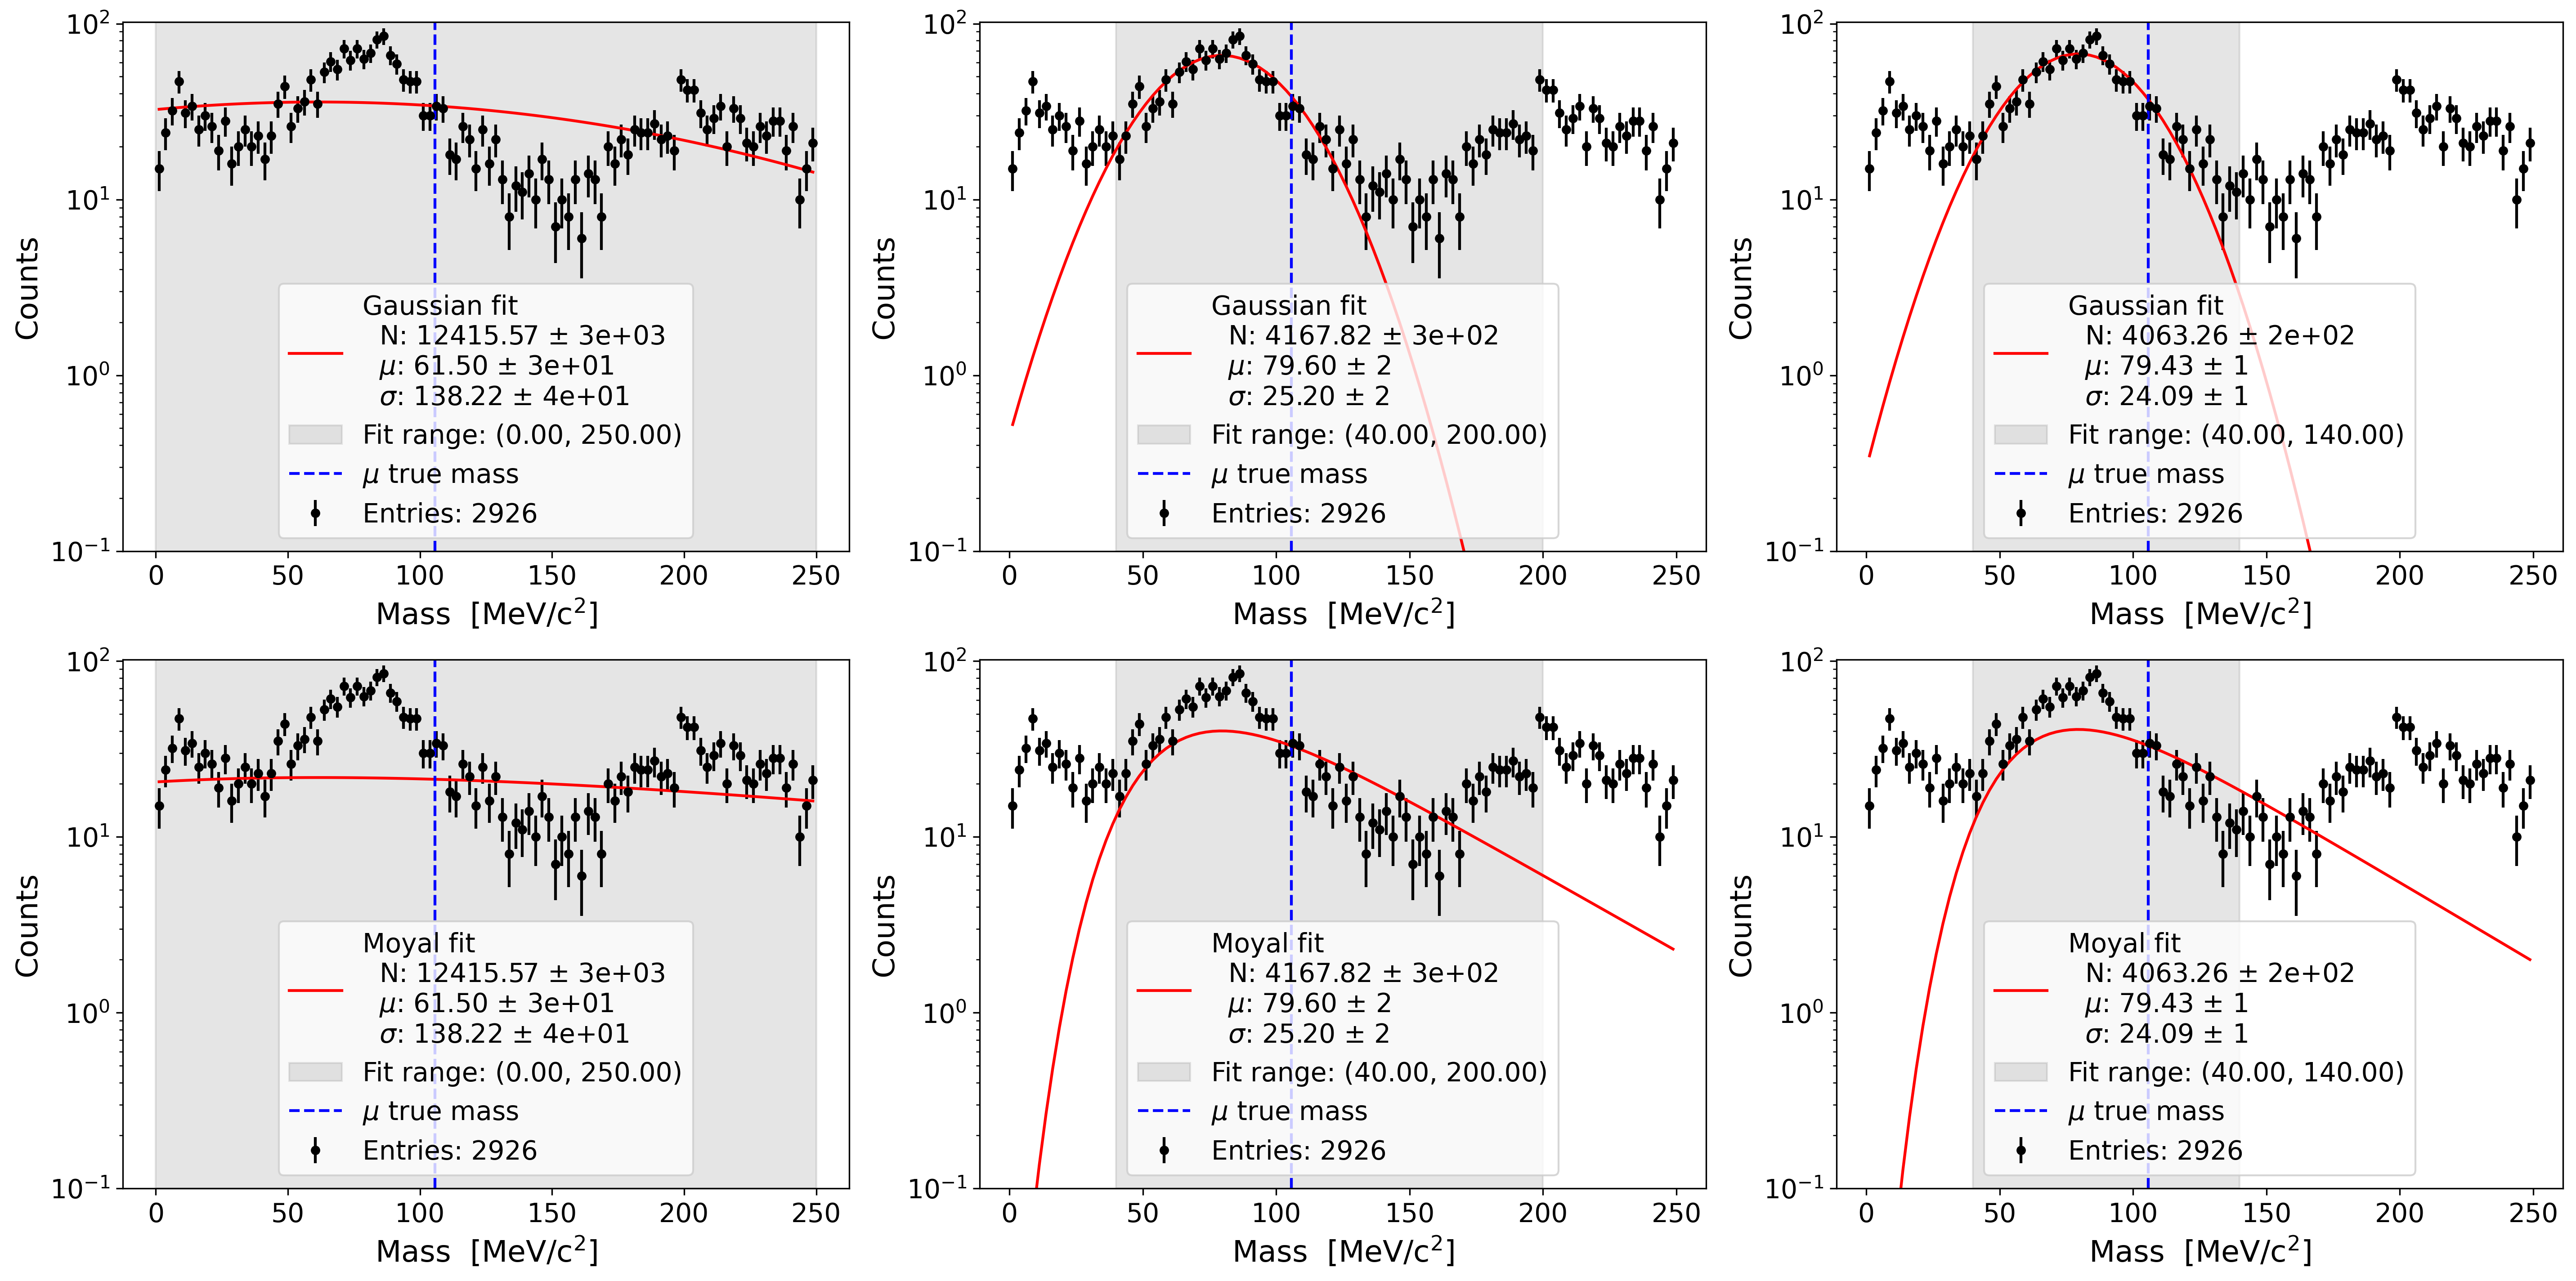

In [258]:
bins = 100
xrange = (0, 250)
ymin, ymax = 0.1, max(40, max(np.histogram(mass, bins=bins, range=xrange)[0]) * 1.2)  # Extend ymax dynamically
ylim = (ymin, ymax)
fit_ranges = ((0, 250), (40, 200), (40, 140))
funcs = {'Gaussian': norm.pdf, 'Moyal': moyal.pdf}

h, b = np.histogram(mass, bins=bins, range=xrange)[:2]
x = (b[1:] + b[:-1]) / 2

fig, axs = plt.subplots(len(funcs), len(fit_ranges), figsize=(mpl.rcParams['figure.figsize'][0] * len(fit_ranges), mpl.rcParams['figure.figsize'][1] * len(funcs)), dpi=300)
axs = np.ravel(axs)

for i, ax in enumerate(axs):
    func_label = list(funcs.keys())[int(int(i / len(fit_ranges)))]
    
    ax.errorbar(x, h, yerr=np.sqrt(h), markersize=4, fmt='o', color='k', label='Entries: {}'.format(np.nansum(h)))[:2]
    
    xmin, xmax = fit_ranges[i % len(fit_ranges)]
    fit_mask = (x > xmin) & (x < xmax)
    
    p0 = [np.nansum(h), np.nanmax(h[fit_mask]), 100]
    p, pcov = curve_fit(lambda x, *p: p[0] * norm.pdf(x, *p[1:]), x[fit_mask], h[fit_mask], p0=p0)
    
    ax.plot(x, p[0] * funcs[func_label](x, *p[1:]), color='r', label='\n  '.join([func_label + ' fit'] + ['{}: {:.2f} $\pm$ {:.1g}'.format(par, p[i], np.sqrt(pcov[i, i])) for i, par in enumerate(['N', '$\mu$', '$\sigma$'])]))
    ax.fill_betweenx(ylim, [xmin]*2, [xmax]*2, alpha=0.2, color='gray', label='Fit range: ({:.2f}, {:.2f})'.format(xmin, xmax))
    ax.vlines([105.66], *ylim, ls='dashed', color='blue', label='$\mu$ true mass')
    
    ax.set_ylim(*ylim)
    ax.set_yscale('log')
    ax.set_xlabel('Mass  [MeV/c$^2$]', fontsize=16)
    ax.set_ylabel('Counts', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend(fontsize=14, loc='lower center')

plt.tight_layout()
plt.savefig('8Fe1Pb10degmassfit', dpi=300)
plt.show()
